In [1]:
from google.colab import drive
from os import listdir
from os.path import isfile, join
from scipy.io import loadmat
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import random

import datetime
import os

In [2]:
# Establecemos conexión con Google Drive para acceder a la carpeta de datasets
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Guardamos la dirección de los datasets (experimentos) en una variable para utilizala posteriormente
dataset_datos_dir = 'drive/MyDrive/DATOS_EXPERIMENTALES_JACKET/DATOS'

In [4]:
# Obtenemos una lista con todos los nombres de los archivos relacionados a los experimentos realizados
dataset_datos_files = [dataset_datos_dir+'/'+filename for filename in listdir(dataset_datos_dir) if isfile(join(dataset_datos_dir, filename))]

In [5]:
# Creamos listas en donde se almacenarán los archivos relacionados a experimentos de fisura y experimentos de perno flojo respectivamente
datos_fisura = []
datos_pernoflojo = []
datos_replica = []
datos_normal = []

In [6]:
# Iteramos los nombres de todos los archivos en la lista general previamente creada
for filename in listdir(dataset_datos_dir):
  # Obtenemos el nombre del archivo tal cual, sin direcciones previas
  if isfile(join(dataset_datos_dir, filename)):
    nombre_archivo = filename.split('.')[0]
    # El estado de fisura se asocia al número 3 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_fisura
    if (nombre_archivo.split('_')[0] == '3'):
      datos_fisura.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '4'):
      datos_pernoflojo.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '1'):
      datos_normal.append(dataset_datos_dir + '/' + filename)
    # El estado de fisura se asocia al número 4 en los nombres de los archivos, si cumple la condición el archivo, guardamos en la lista datos_pernoflojo
    elif (nombre_archivo.split('_')[0] == '2'):
      datos_replica.append(dataset_datos_dir + '/' + filename)

In [7]:
len(datos_normal)

40

In [8]:
len(datos_replica)

20

In [9]:
len(datos_fisura)

20

In [10]:
len(datos_pernoflojo)

20

## Datos Fisura

In [11]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_fisura = []
amplitud_experimentos_fisura = []

In [12]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_fisura:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_fisura creada anteriormente
  numero_experimentos_fisura.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_fisura creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_fisura.append(amplitud_experimento)
  else:
    amplitud_experimentos_fisura.append(int(amplitud_experimento))

In [13]:
# Creamos un DataFrame vacío
df_fisura = pd.DataFrame()

In [14]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_fisura)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_fisura[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_fisura[indice]
  df['amplitud'] = amplitud_experimentos_fisura[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_fisura = pd.concat([df_fisura, df], axis = 0)

In [15]:
# Revisamos el conjunto de datos obtenido para fisura
df_fisura.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000132,0.000185,0.000122,0.000105,0.000141,0.000075,0.000007,0.000231,0.000299,0.000113,0.000228,0.000225,0.000168,0.000018,0.000344,0.000275,-0.000017,0.000046,0.000200,0.000169,0.000097,0.000196,-0.000053,0.000018,1,1.0
1,0.000092,0.000223,0.000166,0.000127,0.000191,0.000137,0.000075,0.000192,0.000240,0.000095,0.000279,0.000231,0.000145,0.000037,0.000339,0.000092,0.000085,0.000074,0.000128,0.000163,0.000074,0.000085,0.000063,-0.000027,1,1.0
2,0.000091,0.000280,0.000188,0.000130,0.000172,0.000102,0.000161,0.000158,0.000211,0.000123,0.000269,0.000206,0.000198,0.000041,0.000312,0.000179,0.000011,0.000079,0.000117,0.000146,0.000085,0.000089,-0.000014,0.000020,1,1.0
3,0.000179,0.000199,0.000249,0.000102,0.000268,0.000140,0.000126,0.000231,0.000239,0.000102,0.000284,0.000175,0.000164,0.000082,0.000311,0.000235,0.000031,0.000079,0.000257,0.000110,0.000050,0.000120,0.000080,0.000057,1,1.0
4,0.000282,0.000277,0.000202,0.000211,0.000251,0.000159,0.000096,0.000205,0.000342,0.000113,0.000240,0.000272,0.000214,0.000057,0.000304,0.000302,0.000047,0.000150,0.000271,0.000168,0.000126,0.000224,0.000105,0.000058,1,1.0
5,0.000005,0.000196,0.000247,0.000109,0.000186,0.000115,0.000042,0.000129,0.000255,0.000108,0.000315,0.000214,0.000237,-0.000001,0.000334,0.000202,-0.000008,0.000081,0.000173,0.000165,0.000126,0.000107,-0.000012,0.000006,1,1.0
6,0.000176,0.000372,0.000223,0.000154,0.000258,0.000165,0.000170,0.000157,0.000228,0.000126,0.000282,0.000219,0.000198,0.000081,0.000333,0.000146,0.000065,0.000070,0.000140,0.000145,0.000099,0.000115,0.000068,-0.000031,1,1.0
7,0.000133,0.000171,0.000187,0.000182,0.000237,0.000159,0.000121,0.000280,0.000293,0.000096,0.000248,0.000202,0.000160,0.000015,0.000319,0.000335,-0.000004,0.000102,0.000201,0.000193,0.000180,0.000171,-0.000009,0.000095,1,1.0


In [16]:
# Si dividimos para 99097 el df_fisura deberíamos obtener 20 experimentos en total
len(df_fisura)/99097

20.0

In [17]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_fisura = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_fisura["#_exp"] == i
    filter2 = df_fisura["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_fisura.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_fisura.append(arreglo_matrices_asociadas)

In [18]:
len(arreglo_imagenes_por_experimento_fisura)

20

In [19]:
len(arreglo_imagenes_por_experimento_fisura[0])

24

In [20]:
len(arreglo_imagenes_por_experimento_fisura[0][0])

64

In [21]:
arreglo_imagenes_por_experimento_fisura[0][0][0].size

256

In [22]:
arreglo_imagenes_por_experimento_fisura[0][0][0].shape

(16, 16)

In [23]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_fisura = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento in arreglo_imagenes_por_experimento_fisura:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_fisura.append(np.dstack(imagen))

In [24]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_fisura)

1280

In [25]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_fisura = randint(0, len(arreglo_imagenes_fisura) - 1)
arreglo_imagenes_fisura[indice_imagen_fisura].shape, type(arreglo_imagenes_fisura[0]), indice_imagen_fisura

((16, 16, 24), numpy.ndarray, 1268)

In [26]:
imagenes_fisura_05 = []
imagenes_fisura_1 = []
imagenes_fisura_2 = []
imagenes_fisura_3 = []

In [27]:
lista_indices = [0]
indice_contador = 0

while indice_contador < 1280:
  indice_contador = indice_contador + 64
  lista_indices.append(indice_contador)
print(lista_indices)

[0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280]


In [28]:
# indices paa fisura, pernoflojo y replica
indices_05 = [1, 5, 9, 13, 17]
indices_1 = [2, 6, 10, 14, 18]
indices_2 = [3, 7, 11, 15, 19]
indices_3 = [4, 8, 12, 16, 20]

In [29]:
for i in indices_05:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_fisura[lista_indices[i-1]:lista_indices[i]]:
    imagenes_fisura_3.append(j)

In [30]:
len(imagenes_fisura_05), len(imagenes_fisura_1), len(imagenes_fisura_2), len(imagenes_fisura_3)

(320, 320, 320, 320)

## Datos Pernoflojo

In [31]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_pernoflojo = []
amplitud_experimentos_pernoflojo = []

In [32]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_pernoflojo:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_pernoflojo creada anteriormente
  numero_experimentos_pernoflojo.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_pernoflojo creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_pernoflojo.append(amplitud_experimento)
  else:
    amplitud_experimentos_pernoflojo.append(int(amplitud_experimento))

In [33]:
# Creamos un DataFrame vacío
df_pernoflojo = pd.DataFrame()

In [34]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_pernoflojo)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_pernoflojo[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_pernoflojo[indice]
  df['amplitud'] = amplitud_experimentos_pernoflojo[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_pernoflojo = pd.concat([df_pernoflojo, df], axis = 0)

In [35]:
# Revisamos el conjunto de datos obtenido para pernoflojo
df_pernoflojo.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000168,0.000204,0.000213,0.000135,0.000201,0.000099,0.000108,0.000189,0.000212,0.000093,0.000257,0.000196,0.000173,0.000029,0.000316,0.000202,0.000010,0.000085,0.000151,0.000136,0.000116,0.000099,0.000054,0.000111,1,0.5
1,0.000122,0.000277,0.000213,0.000180,0.000230,0.000172,0.000068,0.000213,0.000214,0.000095,0.000272,0.000172,0.000173,0.000050,0.000292,0.000178,0.000021,0.000022,0.000203,0.000139,0.000076,0.000164,0.000089,0.000076,1,0.5
2,0.000099,0.000214,0.000128,0.000153,0.000217,0.000100,0.000064,0.000174,0.000225,0.000116,0.000245,0.000202,0.000140,0.000012,0.000309,0.000256,0.000023,0.000089,0.000225,0.000162,0.000098,0.000154,0.000091,0.000092,1,0.5
3,0.000150,0.000258,0.000209,0.000163,0.000213,0.000120,0.000066,0.000157,0.000220,0.000096,0.000229,0.000203,0.000157,0.000057,0.000292,0.000260,0.000062,0.000077,0.000212,0.000178,0.000123,0.000150,0.000056,0.000130,1,0.5
4,0.000194,0.000244,0.000194,0.000201,0.000202,0.000127,0.000133,0.000197,0.000212,0.000110,0.000266,0.000199,0.000181,0.000040,0.000336,0.000209,0.000092,0.000097,0.000183,0.000170,0.000114,0.000127,0.000064,0.000087,1,0.5
5,0.000156,0.000287,0.000188,0.000119,0.000234,0.000127,0.000102,0.000198,0.000216,0.000097,0.000280,0.000222,0.000140,0.000058,0.000296,0.000212,0.000061,0.000097,0.000231,0.000156,0.000090,0.000155,0.000076,0.000091,1,0.5
6,0.000150,0.000230,0.000198,0.000239,0.000247,0.000150,0.000052,0.000178,0.000255,0.000115,0.000235,0.000189,0.000216,0.000072,0.000299,0.000233,0.000060,0.000124,0.000225,0.000157,0.000133,0.000153,0.000060,0.000087,1,0.5
7,0.000130,0.000230,0.000207,0.000116,0.000212,0.000108,0.000096,0.000178,0.000200,0.000130,0.000260,0.000203,0.000216,0.000057,0.000329,0.000261,0.000031,0.000045,0.000236,0.000178,0.000081,0.000160,0.000079,0.000115,1,0.5


In [36]:
# Si dividimos para 99097 el df_pernoflojo deberíamos obtener 20 experimentos en total
len(df_pernoflojo)/99097

20.0

In [37]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_pernoflojo = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_pernoflojo["#_exp"] == i
    filter2 = df_pernoflojo["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_pernoflojo.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_pernoflojo.append(arreglo_matrices_asociadas)

In [38]:
len(arreglo_imagenes_por_experimento_pernoflojo)

20

In [39]:
len(arreglo_imagenes_por_experimento_pernoflojo[0])

24

In [40]:
len(arreglo_imagenes_por_experimento_pernoflojo[0][0])

64

In [41]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].size

256

In [42]:
arreglo_imagenes_por_experimento_pernoflojo[0][0][0].shape

(16, 16)

In [43]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_pernoflojo = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento_i in arreglo_imagenes_por_experimento_pernoflojo:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento_i:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_pernoflojo.append(np.dstack(imagen))

In [44]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_pernoflojo)

1280

In [45]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_pernoflojo = randint(0, len(arreglo_imagenes_pernoflojo) - 1)
arreglo_imagenes_pernoflojo[indice_imagen_pernoflojo].shape, type(arreglo_imagenes_pernoflojo[0]), indice_imagen_pernoflojo

((16, 16, 24), numpy.ndarray, 543)

In [46]:
imagenes_pernoflojo_05 = []
imagenes_pernoflojo_1 = []
imagenes_pernoflojo_2 = []
imagenes_pernoflojo_3 = []

In [47]:
for i in indices_05:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_pernoflojo[lista_indices[i-1]:lista_indices[i]]:
    imagenes_pernoflojo_3.append(j)

In [48]:
len(imagenes_pernoflojo_05), len(imagenes_pernoflojo_1), len(imagenes_pernoflojo_2), len(imagenes_pernoflojo_3)

(320, 320, 320, 320)

## Datos Réplica

In [49]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_replica = []
amplitud_experimentos_replica = []

In [50]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_replica:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_pernoflojo creada anteriormente
  numero_experimentos_replica.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_pernoflojo creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_replica.append(amplitud_experimento)
  else:
    amplitud_experimentos_replica.append(int(amplitud_experimento))

In [51]:
# Creamos un DataFrame vacío
df_replica = pd.DataFrame()

In [52]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_replica)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_replica[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_replica[indice]
  df['amplitud'] = amplitud_experimentos_replica[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_replica = pd.concat([df_replica, df], axis = 0)

In [53]:
# Revisamos el conjunto de datos obtenido para pernoflojo
df_replica.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000355,0.000146,0.000121,-0.000051,0.000056,0.000194,0.000148,0.000252,0.000287,0.000166,0.000288,0.000208,0.000073,-0.000037,0.000383,0.000238,-0.000084,0.000068,0.000064,0.000306,0.000121,0.000112,-0.000216,-0.000085,1,2.0
1,0.000009,0.000346,0.000240,0.000186,0.000230,0.000027,0.000124,0.000234,0.000363,0.000107,0.000293,0.000239,0.000226,0.000112,0.000393,0.000189,0.000072,0.000068,0.000349,-0.000049,0.000153,0.000133,0.000252,-0.000033,1,2.0
2,0.000136,0.000251,0.000098,0.000175,0.000150,0.000184,0.000024,0.000227,0.000300,0.000195,0.000285,0.000293,0.000143,-0.000009,0.000391,0.000449,0.000009,0.000091,0.000292,0.000251,0.000180,0.000326,0.000021,-0.000019,1,2.0
3,0.000190,0.000126,0.000240,-0.000056,0.000113,0.000203,0.000062,0.000145,0.000325,0.000121,0.000311,0.000234,0.000121,0.000031,0.000378,0.000146,0.000051,0.000073,0.000128,0.000138,0.000127,0.000097,0.000057,-0.000052,1,2.0
4,0.000120,0.000354,0.000238,0.000325,0.000146,0.000057,0.000213,0.000164,0.000299,0.000175,0.000261,0.000269,0.000210,0.000105,0.000377,0.000047,0.000086,0.000059,0.000112,0.000112,0.000163,0.000085,0.000090,-0.000045,1,2.0
5,0.000165,0.000087,0.000249,0.000091,0.000189,0.000228,0.000141,0.000269,0.000243,0.000153,0.000298,0.000194,0.000151,-0.000044,0.000420,0.000306,-0.000079,0.000036,0.000206,0.000246,0.000181,0.000216,-0.000106,-0.000053,1,2.0
6,0.000381,0.000427,0.000296,0.000122,0.000299,0.000188,0.000057,0.000121,0.000329,0.000104,0.000272,0.000298,0.000175,0.000117,0.000428,0.000291,0.000160,0.000079,0.000376,-0.000016,0.000150,0.000189,0.000330,0.000022,1,2.0
7,-0.000010,0.000209,0.000437,0.000280,0.000213,0.000170,0.000087,0.000213,0.000379,0.000220,0.000264,0.000232,0.000239,-0.000024,0.000379,0.000287,-0.000056,0.000125,0.000168,0.000271,0.000246,0.000212,-0.000227,-0.000066,1,2.0


In [54]:
# Si dividimos para 99097 el df_pernoflojo deberíamos obtener 20 experimentos en total
len(df_pernoflojo)/99097

20.0

In [55]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentos = [1, 2, 3, 4, 5]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_replica = []

# Iteramos por experimento y por nivel de white noise
for i in experimentos:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_replica["#_exp"] == i
    filter2 = df_replica["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_replica.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_replica.append(arreglo_matrices_asociadas)

In [56]:
len(arreglo_imagenes_por_experimento_replica)

20

In [57]:
len(arreglo_imagenes_por_experimento_replica[0])

24

In [58]:
len(arreglo_imagenes_por_experimento_replica[0][0])

64

In [59]:
arreglo_imagenes_por_experimento_replica[0][0][0].size

256

In [60]:
arreglo_imagenes_por_experimento_replica[0][0][0].shape

(16, 16)

In [61]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_replica = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento_i in arreglo_imagenes_por_experimento_replica:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento_i:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_replica.append(np.dstack(imagen))

In [62]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_replica)

1280

In [63]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_replica = randint(0, len(arreglo_imagenes_replica) - 1)
arreglo_imagenes_replica[indice_imagen_replica].shape, type(arreglo_imagenes_replica[0]), indice_imagen_replica

((16, 16, 24), numpy.ndarray, 1225)

In [64]:
imagenes_replica_05 = []
imagenes_replica_1 = []
imagenes_replica_2 = []
imagenes_replica_3 = []

In [65]:
for i in indices_05:
  for j in arreglo_imagenes_replica[lista_indices[i-1]:lista_indices[i]]:
    imagenes_replica_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_replica[lista_indices[i-1]:lista_indices[i]]:
    imagenes_replica_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_replica[lista_indices[i-1]:lista_indices[i]]:
    imagenes_replica_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_replica[lista_indices[i-1]:lista_indices[i]]:
    imagenes_replica_3.append(j)

In [66]:
len(imagenes_replica_05), len(imagenes_replica_1), len(imagenes_replica_2), len(imagenes_replica_3)

(320, 320, 320, 320)

## Datos Normal

In [67]:
# Se crean 2 listas, una asociada al número de experimento y otra asociada al nivel de white noise presente durante el experimento 
numero_experimentos_normal = []
amplitud_experimentos_normal = []

In [68]:
# Iteramos los nombres de los archivos dentro del conjunto que contiene los datos de fisura
for nombre_archivo in datos_normal:
  # Obtenemos el nombre del experimento
  nombre_experimento = nombre_archivo.split('/')[4]
  # Obtenemos el número del experimento
  numero_experimento = nombre_experimento.split('_')[1]
  # Obtenemos el nivel de white noise del experimento
  amplitud_experimento = nombre_experimento.split('.')[0].split('_')[2].replace('A', '')
  # Agregamos el número del experimento a la lista numero_experimentos_pernoflojo creada anteriormente
  numero_experimentos_normal.append(int(numero_experimento))
  # Agregamos el nivel de white noise del experimento a la lista amplitud_experimentos_pernoflojo creada anteriormente
  if amplitud_experimento == '05':
    amplitud_experimento = 0.5
    amplitud_experimentos_normal.append(amplitud_experimento)
  else:
    amplitud_experimentos_normal.append(int(amplitud_experimento))

In [69]:
# Creamos un DataFrame vacío
df_normal = pd.DataFrame()

In [70]:
# Iteramos por rango la lista datos_fisura
for indice in range(len(datos_normal)):
  # Obtenemos la dirección dentro de la iteración correspondiente
  direccion = datos_normal[indice]
  # Transformamos el .mat a un formato en el que se pueda transformar a DataFrame
  mat = loadmat(direccion)
  df = pd.DataFrame(mat['data'])
  # Para todos los valores del experimento, creamos columnas en donde sus valores se asocian con el nivel de wn y el # de experimento
  df['#_exp'] = numero_experimentos_normal[indice]
  df['amplitud'] = amplitud_experimentos_normal[indice]
  # Colocamos al final del DataFrame df_fisura creado el nuevo DataFrame 
  df_normal = pd.concat([df_normal, df], axis = 0)

In [71]:
# Revisamos el conjunto de datos obtenido para pernoflojo
df_normal.head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,#_exp,amplitud
0,0.000164,0.000316,0.000257,0.000163,0.000217,0.000159,0.000133,0.000218,0.000316,0.000102,0.000274,0.000244,0.000157,0.000038,0.000348,0.000246,0.000031,0.000106,0.000199,0.000195,0.000147,0.000097,0.000086,-0.000012,1,0.5
1,0.000145,0.000225,0.000230,0.000150,0.000207,0.000144,0.000114,0.000210,0.000329,0.000157,0.000273,0.000263,0.000197,0.000086,0.000392,0.000279,0.000058,0.000102,0.000273,0.000165,0.000207,0.000197,0.000104,0.000011,1,0.5
2,0.000192,0.000263,0.000266,0.000179,0.000199,0.000202,0.000073,0.000173,0.000334,0.000112,0.000264,0.000205,0.000195,0.000054,0.000383,0.000261,0.000009,0.000058,0.000270,0.000182,0.000165,0.000172,0.000084,-0.000006,1,0.5
3,0.000182,0.000258,0.000243,0.000177,0.000252,0.000200,0.000122,0.000200,0.000348,0.000162,0.000270,0.000250,0.000192,0.000021,0.000351,0.000183,0.000024,0.000067,0.000211,0.000210,0.000136,0.000174,0.000068,-0.000037,1,0.5
4,0.000150,0.000261,0.000177,0.000153,0.000195,0.000160,0.000100,0.000196,0.000298,0.000116,0.000289,0.000225,0.000132,0.000028,0.000353,0.000202,-0.000009,0.000075,0.000197,0.000185,0.000117,0.000130,0.000027,-0.000029,1,0.5
5,0.000142,0.000305,0.000240,0.000157,0.000202,0.000155,0.000127,0.000224,0.000341,0.000131,0.000272,0.000254,0.000170,0.000051,0.000403,0.000213,0.000056,0.000096,0.000248,0.000136,0.000183,0.000220,0.000062,-0.000062,1,0.5
6,0.000137,0.000227,0.000229,0.000136,0.000189,0.000139,0.000080,0.000173,0.000335,0.000158,0.000237,0.000250,0.000213,0.000045,0.000417,0.000219,-0.000008,0.000092,0.000242,0.000146,0.000136,0.000185,0.000022,0.000015,1,0.5
7,0.000138,0.000244,0.000208,0.000149,0.000181,0.000118,0.000099,0.000144,0.000282,0.000162,0.000263,0.000242,0.000211,0.000035,0.000382,0.000178,0.000087,0.000085,0.000183,0.000130,0.000100,0.000147,0.000056,-0.000007,1,0.5


In [72]:
# Si dividimos para 99097 el df_pernoflojo deberíamos obtener 20 experimentos en total NO SABEMOS TODAVIA
len(df_normal)/99097

40.0

In [73]:
# Establecemos 2 listas, una con los posibles experimentos y otra con los posibles niveles de white noise, lo cual nos ayudará a segmentar los datos
experimentosn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
wns = [0.5, 1, 2, 3]
# Creamos una lista en donde pondremos todas las imágenes creadas, segmentadas por experimento y white noise
arreglo_imagenes_por_experimento_normal = []

# Iteramos por experimento y por nivel de white noise
for i in experimentosn:
  for j in wns:
    # Creamos filtros que nos permiten identificar el experimento por su número asociado y por su nivel de white noise dentro del conjunto de datos
    filter1 = df_normal["#_exp"] == i
    filter2 = df_normal["amplitud"] == j
    # Filtramos y deshacemos las filas que no corresponden a la búsqueda
    dataset_experimento = df_normal.where(filter1 & filter2).dropna()
    # Creamos arreglo en donde almacenaremos listas de imágenes asociadas a cada columna en un experimento individual
    arreglo_matrices_asociadas = []

    # En el conjunto filtrado, iteramos por cada columna (de la columna 0 a la 23)
    for n in range(24):
      # Establecemos un límite inferior y un límite superior
      indice_inicio = 0
      indice_fin = 256
      # Del conjunto filtrado, obtenemos un subconjunto con muestras cada 6 pasos
      columna_cada_6 = dataset_experimento[n][::6]
      # Creamos una lista en donde guardaremos todas las imágenes creadas dentro de la columna en la que se esta iterando
      matrices_columna = []
    
      # Recorremos en valores de 256 la columna del subconjunto creado para generar las imágenes 16x16 correspondientes 
      while indice_fin < len(columna_cada_6):
        # Guardamos el conjunto de 256 datos dentro de un arreglo
        vector = columna_cada_6[indice_inicio:indice_fin]
        # Redimensionamos el arreglo (de 1x256 a 16x16)
        matriz = vector.to_numpy().reshape((16, 16))
        # Agregamos la imagen dentro de la lista matrices_columna
        matrices_columna.append(matriz)
        # Establecemos el nuevo límite inferior y superior en donde se encontrarán los datos de mi nueva imagen 16x16
        indice_inicio = indice_fin
        indice_fin = indice_fin + 256
      
      # Agregamos las listas de imágenes 16x16 asociadas a una columna a arreglo_matrices_asociadas
      arreglo_matrices_asociadas.append(matrices_columna)
    
    # Agregamos arreglo_matrices_asociadas a arreglos_imagenes_por_experimento, en donde tenemos listas de listas asociadas a un experimento individual
    arreglo_imagenes_por_experimento_normal.append(arreglo_matrices_asociadas)

In [74]:
len(arreglo_imagenes_por_experimento_normal)

40

In [75]:
len(arreglo_imagenes_por_experimento_normal[0])

24

In [76]:
len(arreglo_imagenes_por_experimento_normal[0][0])

64

In [77]:
arreglo_imagenes_por_experimento_normal[0][0][0].size

256

In [78]:
arreglo_imagenes_por_experimento_normal[0][0][0].shape

(16, 16)

In [79]:
# Creamos un arreglos general para todas las imágenes de dimensionamiento (24, 16, 16)
arreglo_imagenes_normal = []

# Iteramos cada experimento en la lista de experimentos creada previamente
for experimento_i in arreglo_imagenes_por_experimento_normal:
  # Iteramos en un rango de 64 para usarlo posteriormente
  for idx in range(64):
    # Para cada iteración se crea el arreglo en donde se agregaran las capas correctas de la imagen de dimensionamniento (24, 16, 16)
    imagen = []
    # Iteramos para cada fila en el experimento (son 24 filas)
    for fila in experimento_i:
      # Asociamos por índice los valores de cada lista de imágenes para establecer la relación correcta y agregamos al arreglo creado
      capa_imagen = fila[idx]
      imagen.append(capa_imagen)

    # Transformamos la lista de 24 capas a un arreglo numérico
    arreglo_imagenes_normal.append(np.dstack(imagen))

In [80]:
# Revisamos el número de imágenes creadas
len(arreglo_imagenes_normal)

2560

In [81]:
# Revisamos el dimensionamiento y tipo de un elemento aleatorio en la lista de imágenes
indice_imagen_normal = randint(0, len(arreglo_imagenes_normal) - 1)
arreglo_imagenes_normal[indice_imagen_normal].shape, type(arreglo_imagenes_normal[0]), indice_imagen_normal

((16, 16, 24), numpy.ndarray, 897)

In [82]:
arreglo_imagenes_normal_1 = arreglo_imagenes_normal[:1280]
arreglo_imagenes_normal_2 = arreglo_imagenes_normal[1280:]

In [83]:
imagenes_normal_05 = []
imagenes_normal_1 = []
imagenes_normal_2 = []
imagenes_normal_3 = []

In [84]:
for i in indices_05:
  for j in arreglo_imagenes_normal_1[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_normal_1[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_normal_1[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_normal_1[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_3.append(j)

In [85]:
for i in indices_05:
  for j in arreglo_imagenes_normal_2[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_05.append(j)
for i in indices_1:
  for j in arreglo_imagenes_normal_2[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_1.append(j)
for i in indices_2:
  for j in arreglo_imagenes_normal_2[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_2.append(j)
for i in indices_3:
  for j in arreglo_imagenes_normal_2[lista_indices[i-1]:lista_indices[i]]:
    imagenes_normal_3.append(j)

In [86]:
len(imagenes_normal_05), len(imagenes_normal_1), len(imagenes_normal_2), len(imagenes_normal_3)

(640, 640, 640, 640)

## Aleatorizar

In [87]:
np.random.seed(300)

aleatorizadas_imagenes_fisura_05 = imagenes_fisura_05
aleatorizadas_imagenes_fisura_1 = imagenes_fisura_1
aleatorizadas_imagenes_fisura_2 = imagenes_fisura_2
aleatorizadas_imagenes_fisura_3 = imagenes_fisura_3

aleatorizadas_imagenes_pernoflojo_05 = imagenes_pernoflojo_05
aleatorizadas_imagenes_pernoflojo_1 = imagenes_pernoflojo_1
aleatorizadas_imagenes_pernoflojo_2 = imagenes_pernoflojo_2
aleatorizadas_imagenes_pernoflojo_3 = imagenes_pernoflojo_3

aleatorizadas_imagenes_replica_05 = imagenes_replica_05
aleatorizadas_imagenes_replica_1 = imagenes_replica_1
aleatorizadas_imagenes_replica_2 = imagenes_replica_2
aleatorizadas_imagenes_replica_3 = imagenes_replica_3

aleatorizadas_imagenes_normal_05 = imagenes_normal_05
aleatorizadas_imagenes_normal_1 = imagenes_normal_1
aleatorizadas_imagenes_normal_2 = imagenes_normal_2
aleatorizadas_imagenes_normal_3 = imagenes_normal_3

np.random.shuffle(aleatorizadas_imagenes_fisura_05)
np.random.shuffle(aleatorizadas_imagenes_fisura_1)
np.random.shuffle(aleatorizadas_imagenes_fisura_2)
np.random.shuffle(aleatorizadas_imagenes_fisura_3)

np.random.shuffle(aleatorizadas_imagenes_pernoflojo_05)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_1)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_2)
np.random.shuffle(aleatorizadas_imagenes_pernoflojo_3)

np.random.shuffle(aleatorizadas_imagenes_replica_05)
np.random.shuffle(aleatorizadas_imagenes_replica_1)
np.random.shuffle(aleatorizadas_imagenes_replica_2)
np.random.shuffle(aleatorizadas_imagenes_replica_3)

np.random.shuffle(aleatorizadas_imagenes_normal_05)
np.random.shuffle(aleatorizadas_imagenes_normal_1)
np.random.shuffle(aleatorizadas_imagenes_normal_2)
np.random.shuffle(aleatorizadas_imagenes_normal_3)

In [88]:
lista_listas_imagenes_fallos = [aleatorizadas_imagenes_fisura_05, aleatorizadas_imagenes_fisura_1, aleatorizadas_imagenes_fisura_2, aleatorizadas_imagenes_fisura_3, aleatorizadas_imagenes_pernoflojo_05, aleatorizadas_imagenes_pernoflojo_1, aleatorizadas_imagenes_pernoflojo_2, aleatorizadas_imagenes_pernoflojo_3]
lista_listas_imagenes_sano = [aleatorizadas_imagenes_replica_05, aleatorizadas_imagenes_replica_1, aleatorizadas_imagenes_replica_2, aleatorizadas_imagenes_replica_3, aleatorizadas_imagenes_normal_05, aleatorizadas_imagenes_normal_1, aleatorizadas_imagenes_normal_2, aleatorizadas_imagenes_normal_3]

## Segmentar datos en entrenamiento, validación y prueba

In [89]:
conjunto_entrenamiento_fallos = []
conjunto_validacion_fallos = []
conjunto_prueba_fallos = []

conjunto_entrenamiento_sano = []
conjunto_validacion_sano = []
conjunto_prueba_sano = []

In [90]:
for lista in lista_listas_imagenes_fallos:
  for imagen_entrenamiento in lista[:int(len(lista)*0.8)]:
    conjunto_entrenamiento_fallos.append(imagen_entrenamiento)
  for imagen_validacion in lista[int(len(lista)*0.8):int(len(lista)*0.8) + int(len(lista)*0.1)]:
    conjunto_validacion_fallos.append(imagen_validacion)
  for imagen_prueba in lista[int(len(lista)*0.8) + int(len(lista)*0.1):]:
    conjunto_prueba_fallos.append(imagen_prueba)

for lista in lista_listas_imagenes_sano:
  for imagen_entrenamiento in lista[:int(len(lista)*0.8)]:
    conjunto_entrenamiento_sano.append(imagen_entrenamiento)
  for imagen_validacion in lista[int(len(lista)*0.8):int(len(lista)*0.8) + int(len(lista)*0.1)]:
    conjunto_validacion_sano.append(imagen_validacion)
  for imagen_prueba in lista[int(len(lista)*0.8) + int(len(lista)*0.1):]:
    conjunto_prueba_sano.append(imagen_prueba)

In [91]:
len(conjunto_entrenamiento_fallos), len(conjunto_validacion_fallos), len(conjunto_prueba_fallos)

(2048, 256, 256)

In [92]:
len(conjunto_entrenamiento_sano), len(conjunto_validacion_sano), len(conjunto_prueba_sano)

(3072, 384, 384)

In [93]:
len(conjunto_entrenamiento_sano) - len(conjunto_entrenamiento_fallos)

1024

## Red Siamesa

In [96]:
def crear_pares_entrenamiento(arreglo_imagenes_fallos, arreglo_imagenes_sano):
  """
  Función empleada para crear los pares de imágenes que se utilizan
  para el entrenamiento de la SNN.
  """
  print("Creando pares...")
  # Creamos arreglo en donde se insertarán los pares (positivos y negativos)
  pares_img = []
  # Creamos arreglo en donde se insertarán la clasificación de los pares (similares = 1, no similares = 0)
  pares_label = []

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_fallo in arreglo_imagenes_fallos:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (fisura)
    imagen_positiva_fallo = random.choice(arreglo_imagenes_fallos)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (perno flojo)
    imagen_negativa_fallo = random.choice(arreglo_imagenes_sano)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_fallo, imagen_positiva_fallo])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_fallo, imagen_negativa_fallo])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])

  # Recorremos el arreglo de imágenes de fisura y por cada imagen recorrida creamos un par positivo y uno negativo
  for imagen_sano in arreglo_imagenes_sano:

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (perno flojo)
    imagen_positiva_sano = random.choice(arreglo_imagenes_sano)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (fisura)
    imagen_negativa_sano = random.choice(arreglo_imagenes_fallos)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([imagen_sano, imagen_positiva_sano])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([imagen_sano, imagen_negativa_sano])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])

  for indice_imagen_fallo in range(len(arreglo_imagenes_sano)-len(arreglo_imagenes_fallos)):

    # La imagen positiva será un dato aleatorio perteneciente al arreglo de la misma clase (fisura)
    imagen_positiva_fallo = random.choice(arreglo_imagenes_fallos)
    # La imagen negativa será un dato aleatorio perteneciente al arreglo de la otra clase (perno flojo)
    imagen_negativa_fallo = random.choice(arreglo_imagenes_sano)

    # Agregamos el par de imagenes positivas al arreglo de pares de imagenes
    pares_img.append([arreglo_imagenes_fallos[i], imagen_positiva_fallo])
    # Agregamos el label correspondiente a un par de imágenes positivas (1)
    pares_label.append([1])

    # Agregamos el par de imagenes negativas al arreglo de pares de imagenes
    pares_img.append([arreglo_imagenes_fallos[i], imagen_negativa_fallo])
    # Agregamos el label correspondiente a un par de imágenes negativas (0)
    pares_label.append([0])
  
  print("Pares creados.")

  return (np.array(pares_img), np.array(pares_label))

In [97]:
def euclidean_distance(vectors):
  
  # Descomprimimos los vectores en listas separadas
  (featsA, featsB) = vectors

  # Realizamos la suma de las diferenias cuadradas entre vectores
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)

  # Retornamos la distancia euclidiana
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [98]:
# Definimos función de visualización de pérdidas

def graficar_curva_perdidas(history):
  """
  Función utilizada para visualizar la historia de nuestro modelo.
  Incluye pérdidas y precisión a lo largo de cada iteración.
  """
  # Obtenemos las pérdidas de los conjuntos de entrenamiento y validación
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Obtenemos la precisión de los conjuntos de entrenamiento y validación
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Determinamos las iteraciones que hubo durante el entrenamiento
  epochs = range(len(history.history['loss']))

  # Graficamos las pérdidas de ambos conjuntos a lo largo de las iteraciones
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # Graficamos la precisión de ambos conjuntos a lo largo de las iteraciones
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

In [99]:
(pares_entrenamiento, labels_entrenamiento) = crear_pares_entrenamiento(conjunto_entrenamiento_fallos, conjunto_entrenamiento_sano)
(pares_validacion, labels_validacion) = crear_pares(conjunto_validacion_fallos, conjunto_validacion_sano)
(pares_prueba, labels_prueba) = crear_pares(conjunto_prueba_fallos, conjunto_prueba_sano)

Creando pares...
Pares creados.
Creando pares...
Pares creados.
Creando pares...
Pares creados.


In [100]:
np.random.seed(300)

pares_aleatorizados = pares_entrenamiento
np.random.shuffle(pares_aleatorizados)

In [101]:
np.random.seed(300)

labels_aleatorizados = labels_entrenamiento
np.random.shuffle(labels_aleatorizados)

In [102]:
# Creamos función que retorna la estructura de la red convolucional que se va a utilizar
def build_siamese_model_1(input_shape):
  model = tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters=64,
                                                        kernel_size=3,
                                                        activation='relu',
                                                        padding='same',
                                                        input_shape=input_shape),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=3,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=128,
                                                        kernel_size=3,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.MaxPooling2D(pool_size=2),
                                tf.keras.layers.Conv2D(filters=256,
                                                        kernel_size=3,
                                                        activation='relu',
                                                        padding='same'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(4960)
  ])

  return model

In [103]:
tf.random.set_seed(100)

# Creamos el modelo general
IMG_SHAPE = (16, 16, 24)

# Definimos los inputs (imágenes) que ingresan a cada CNN
imgA = tf.keras.Input(IMG_SHAPE)
imgB = tf.keras.Input(IMG_SHAPE)

# Creamos el featureExtractor, el cual obtiene las características principales de las imágenes ingresadas y las muestra en un vector
featureExtractor = build_siamese_model_1(input_shape=IMG_SHAPE)

# Ingresamos cada imagen al featureExtractor
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# Creamos una capa Lambda (que aplica una función sobre los datos) para obtener la distancia euclidiana
distancia = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

# Creamos la última capa asociada a la función de activación sigmoide
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distancia)

# Establecemos el modelo general
model_1 = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

# Empleamos el loss como binary_crossentropy porque solo queremos saber si las imágenes son similares o no (no queremos clasificarlas)
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                metrics=['accuracy'])

# Hacemos el fit del modelo
history_1 = model_1.fit(
    [pares_aleatorizados[:, 0], pares_aleatorizados[:, 1]], labels_aleatorizados[:],
     validation_data=([pares_validacion[:, 0], pares_validacion[:, 1]], labels_validacion[:]),
     batch_size=32,
     epochs=5
)

Epoch 1/5
384/384 [==============================] - 97s 249ms/step - loss: 0.3292 - accuracy: 0.8630 - val_loss: 0.1630 - val_accuracy: 0.9977
Epoch 2/5
384/384 [==============================] - 94s 246ms/step - loss: 0.1086 - accuracy: 0.9980 - val_loss: 0.0718 - val_accuracy: 0.9992
Epoch 3/5
384/384 [==============================] - 94s 245ms/step - loss: 0.0510 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 4/5
384/384 [==============================] - 94s 245ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 1.0000
Epoch 5/5
384/384 [==============================] - 94s 245ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000


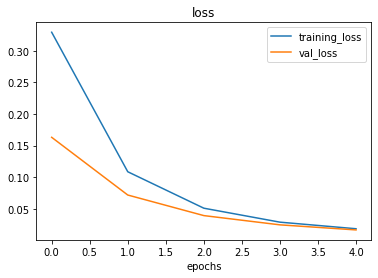

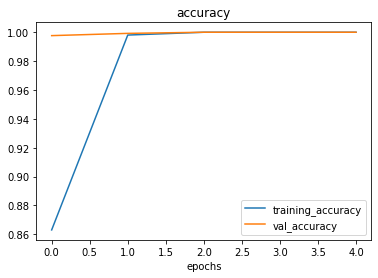

In [104]:
graficar_curva_perdidas(history_1)

## Matriz de confusión

In [105]:
# Creamos una función que nos permita visualizar la matriz de confusión de los resultados
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False,
                     fmt='g')
    plt.xlabel('Label Reales')
    plt.ylabel('Predicciones')

In [106]:
# Guardamos las predicciones en una variable
predicciones = model_1.predict([pares_prueba[:, 0], pares_prueba[:, 1]])

In [107]:
# Redondeamos los valores predecidos para poder compararlos con los valores reales
for i in range(len(predicciones)):
  predicciones[i][0] = round(predicciones[i][0])

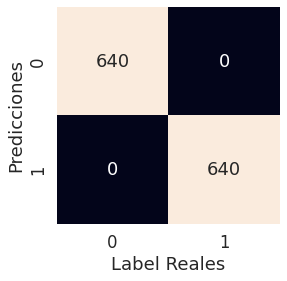

In [108]:
# Graficamos la matriz de confusión
plot_conf_mat(labels_prueba, predicciones)

In [ ]:
# Creamos la función de guardado del modelo
def save_model(model, suffix=None):
  """
  Guarda un modelo en el directorio de modelos y agrega un string.
  """
  # Creamos el pathname del directorio del modelo con el tiempo actual
  model_dir = os.path.join('drive/MyDrive/modelos',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  # Guardado con formato de modelo
  model_path = model_dir + '-' + suffix + '.h5'
  print(f'Guardando modelo en: {model_path}...')
  model.save(model_path)
  return model_path

In [ ]:
modelo_1_path = save_model(model=model_1, suffix='modelo_SNN_TurbinaJacket_fallos_sano_correcion_balance')

Guardando modelo en: drive/MyDrive/modelos/20210723-00011626998475-modelo_SNN_TurbinaJacket_fallos_sano_correcion_balance.h5...
